In [1]:
!pip install pot
!pip install torch
!pip install geomloss
!pip install wget


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd

from geomloss import SamplesLoss

import ot

import os
import pickle as pkl
import copy

from sklearn.preprocessing import scale
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

from utils import *
from SoftImpute import softimpute, cv_softimpute
from DataSetLoader import dataset_loader, ground_truth
from SinkhornImputation import SinkhornImputation
from Sinkhorn_CMI import SinkhornImputation_CMI
from RR_imputer import RRimputer
import matplotlib.pyplot as plt

import argparse
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("test")

torch.set_default_tensor_type('torch.DoubleTensor')

c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


In [3]:
Xy = {}
with open(r'C:\Users\zhossai3\Desktop\My code\OT+Fairness\Data\portugal student performance dataset\P_Student_Performance_Data.csv', 'rb') as f:
        df = pd.read_csv(f, delimiter=',', header = 0)
        Xy['data'] = df.values[:, :-1].astype('float')
        Xy['target'] =  df.values[:, -1]

In [4]:
ground_truth_numpy = scale(Xy['data'])
print(type(ground_truth_numpy))

<class 'numpy.ndarray'>


In [5]:
print(np.max(ground_truth_numpy))
print(np.min(ground_truth_numpy))
print(np.mean(ground_truth_numpy))
print(np.median(ground_truth_numpy))
print(np.std(ground_truth_numpy))

9.150126670101555
-4.7441041972812386
-3.773774598403673e-17
-0.22237479499833032
1.0


In [6]:
print(ground_truth_numpy)

[[-0.34199278 -0.96399841  1.20622289 ...  0.06678691 -4.7441042
  -0.50229837]
 [-0.34199278 -0.96399841  0.35293188 ... -0.3414147  -1.21909226
  -0.50229837]
 [-0.34199278 -0.96399841 -1.35365013 ...  0.47498853 -0.04408828
   0.309025  ]
 ...
 [ 2.9240383  -0.96399841  1.20622289 ...  0.47498853 -0.43575627
  -0.09663668]
 [ 2.9240383   1.03734611  0.35293188 ...  0.47498853 -0.82742427
  -0.90796005]
 [ 2.9240383   1.03734611  1.20622289 ...  0.06678691 -0.82742427
  -0.50229837]]


In [7]:
print(ground_truth_numpy.shape)
ground_truth = torch.from_numpy(ground_truth_numpy)
print(ground_truth.isnan().sum())

(382, 52)
tensor(0)


In [8]:
#30% MCAR
np.random.seed(42)

p_macr30 = 0.301


mask_mcar30 = np.random.rand(*ground_truth.shape) < p_macr30  # True for missing values, false for others
data_mcar30 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar30[mask_mcar30] = np.nan

# Convert to a torch tensor
data_mcar30 = torch.from_numpy(data_mcar30)

# Calculate the percentage of missing values
missing_values_mcar30 = torch.isnan(data_mcar30)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar30 = torch.sum(missing_values_mcar30).item() / data_mcar30.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar30:.2f}%")

Percentage of missing values: 30.01%


In [9]:
data_mcar30_numpy = data_mcar30.detach().cpu().numpy()

In [10]:
#sinkhorn
n_mcar30, d_mcar30 = data_mcar30.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
#epsilon_mcar30 = pick_epsilon(data_mcar30)
epsilon_mcar30 = 0.3
print(epsilon_mcar30)


0.3


In [11]:
sk_imputer_mcar30 = SinkhornImputation_CMI(eps=epsilon_mcar30, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar30, sk_maes30mcar, sk_rmses30mcar,sk_loss_mcar30 = sk_imputer_mcar30.fit_transform(data_mcar30, verbose=True, report_interval=50, X_true=ground_truth)
#using numpy version of data
sk_imp_mcar30_numpy = sk_imp_mcar30.detach().cpu().numpy()

sk_mae_mcar30 = MAE(sk_imp_mcar30_numpy,ground_truth_numpy ,mask_mcar30)
sk_rmse_mcar30 = RMSE(sk_imp_mcar30_numpy, ground_truth_numpy,mask_mcar30)
print(sk_mae_mcar30,sk_rmse_mcar30)

INFO:root:Iteration 0:	 Loss: 16.1526	 Validation MAE: 0.7844	RMSE: 1.0006
INFO:root:Iteration 50:	 Loss: 12.9480	 Validation MAE: 0.6742	RMSE: 0.9353
INFO:root:Iteration 100:	 Loss: 13.1076	 Validation MAE: 0.6535	RMSE: 0.9129
INFO:root:Iteration 150:	 Loss: 11.4803	 Validation MAE: 0.6443	RMSE: 0.9034
INFO:root:Iteration 200:	 Loss: 13.6574	 Validation MAE: 0.6379	RMSE: 0.8970
INFO:root:Iteration 250:	 Loss: 12.7643	 Validation MAE: 0.6337	RMSE: 0.8915
INFO:root:Iteration 300:	 Loss: 12.4690	 Validation MAE: 0.6327	RMSE: 0.8904
INFO:root:Iteration 350:	 Loss: 11.8516	 Validation MAE: 0.6312	RMSE: 0.8878
INFO:root:Iteration 400:	 Loss: 12.5634	 Validation MAE: 0.6298	RMSE: 0.8861
INFO:root:Iteration 450:	 Loss: 12.3581	 Validation MAE: 0.6293	RMSE: 0.8845
INFO:root:Iteration 500:	 Loss: 12.3238	 Validation MAE: 0.6287	RMSE: 0.8829
INFO:root:Iteration 550:	 Loss: 13.2760	 Validation MAE: 0.6275	RMSE: 0.8816
INFO:root:Iteration 600:	 Loss: 13.1092	 Validation MAE: 0.6264	RMSE: 0.8800
IN

0.6285830865674903 0.8819332189623336


In [12]:
print(sk_loss_mcar30)
#sk_loss_mcar30.clear

[16.152641955661984, 12.948014216744514, 13.107571813683439, 11.480313481514411, 13.65742120549049, 12.76426182073048, 12.469017845091646, 11.851580999389386, 12.563419882220035, 12.35811186784073, 12.32376772382501, 13.275990230395818, 13.109236477432665, 12.46989612374036, 13.982583642052813, 12.796532559933318, 13.306368861232784, 12.639996162192372, 13.028526359318068, 14.468650010332054, 12.777943989935316, 13.269897046464843, 13.277848491121931, 12.187556719640796, 13.28895599420361, 13.716924766478982, 14.099672514209772, 13.312755592358661, 13.36355102626184, 13.53494106743183, 13.549547591480412, 14.461813578670405, 13.822247907888222, 13.563494516324466, 12.493075929898406, 13.256075613023281, 13.983627534563407, 12.1685091015641, 12.908622774439474, 13.617133326010263]


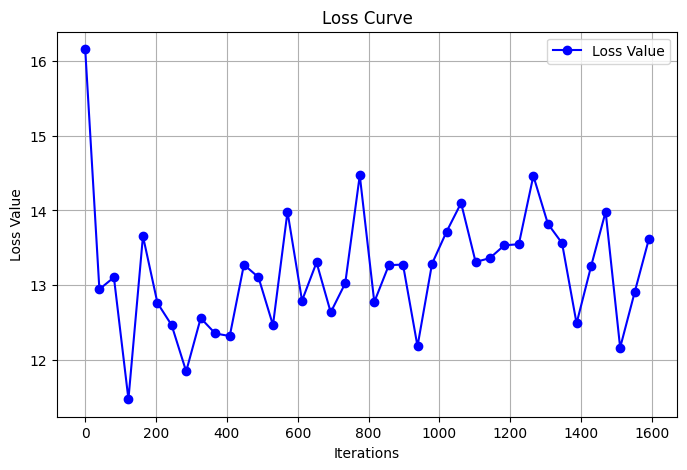

In [13]:
# Convert the list of losses to a NumPy array

iterations = np.linspace(0, 2000, 50).astype(int)



loss_values = sk_loss_mcar30


# Assuming cmi_penalty_history is also a list, convert it to a NumPy array
#cmi_penalty_history_numpy = np.array(cmi_penalty_history)

# Total loss calculation
#total_loss = sk_loss_mcar30_numpy + cmi_penalty_history_numpy
if len(loss_values) > len(iterations):
    loss_values = loss_values[:len(iterations)]
elif len(loss_values) < len(iterations):
    iterations = iterations[:len(loss_values)]



# Plotting
plt.figure(figsize=(8, 5))
plt.plot(iterations, loss_values, color='b', linestyle='-', marker='o', label="Loss Value")
plt.xlabel("Iterations")
plt.ylabel("Loss Value")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

